# Spectural analysis tests

In [5]:
import os
import sys

In [22]:
import h5py
import numpy as np
from glob import glob
from datetime import datetime, timedelta

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

https://github.com/CliMA/diffusion-bridge-downscaling

https://www.mathworks.com/matlabcentral/answers/1974369-how-to-calculate-wavenumber-for-fft2-of-a-2d-array

https://dsp.stackexchange.com/questions/74974/how-to-obtain-the-exact-value-of-wavelength-from-a-2d-fft-amplitude-vs-wavenumbe

In [31]:
from scipy import signal
from scipy.interpolate import RegularGridInterpolator

In [9]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import model_utils as mu

2023-12-28 04:29:23.773299: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-28 04:29:23.852564: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
def norm_precip(x):
    return np.log(x+1)

def norm_rh(x):
    return (x-50)/28/2

def norm_t(x):
    return (x-281)/10/2

def norm_u(x):
    return (x-3.5)/6.5/2

def norm_v(x):
    return (x)/6.5/2

def norm_pwat(x):
    return (x-20.5)/15/2

def norm_cape(x):
    return (x-200)/450/2

In [10]:
total_timesteps = 50 # diffusion time steps
# configure the forward diffusion steps
gdf_util = mu.GaussianDiffusion(timesteps=total_timesteps)

2023-12-28 04:29:28.972688: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 494 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0


In [86]:
input_shape = (32, 32, 8)
gfs_shape = (128, 128, 8)
F_y = 1/6.3 # the scale of VQ-VAE codes

year = 2023
N_days = 365

ini = 0
lead = 6

day_start = 0
day_end = 20

N_ens = 10
thres_zero_mask = 0
thres_high_precip = norm_precip(10)

In [87]:
# data size info
x_mrms = 256; y_mrms = 576 # 0.1 deg MRMS size
x_gfs = 105; y_gfs = 242 # 0.25 deg GFS size

Nx_pred = 2
Ny_pred = 5
Ny_gap = 12
size_pred = 128

base = datetime(year, 1, 1)
date_list = [base + timedelta(days=d) for d in range(N_days)]

# ------- file locations and names ------ #
name_gfs = '/glade/campaign/cisl/aiml/ksha/GFS/GFS_{}_ini{:02d}_f{:02d}.hdf'
name_apcp = '/glade/campaign/cisl/aiml/ksha/GFS/GFS_APCP_{}_ini{:02d}_f{:02d}.hdf'
name_MRMS = '/glade/campaign/cisl/aiml/ksha/GFS/MRMS_y{}.hdf'

In [88]:
with h5py.File(save_dir+'CNN_domain.hdf', 'r') as h5io:
    lon_01 = h5io['lon_01'][...]
    lat_01 = h5io['lat_01'][...]
    elev_01 = h5io['elev_01'][...]
    lon_GFS = h5io['lon_GFS'][...]
    lat_GFS = h5io['lat_GFS'][...]

In [89]:
d

19

In [90]:
# ------- Import data ------- #
with h5py.File(name_MRMS.format(year), 'r') as h5io:
    MRMS = h5io['MRMS'][...]
L_base = len(MRMS)
N_total = L_base

with h5py.File(name_gfs.format(year, ini, lead), 'r') as h5io:
    CAPE = h5io['CAPE'][...]
    PWAT = h5io['PWAT'][...]
    T800 = h5io['T800'][...]
    U800 = h5io['U800'][...]
    V800 = h5io['V800'][...]
    RH800 = h5io['RH800'][...]

with h5py.File(name_apcp.format(year, ini, lead), 'r') as h5io:
    APCP = h5io['APCP'][...]

# ------- data allocations ------- #
data = np.empty((day_end-day_start, x_mrms, y_mrms, 9))
data[...] = np.nan

for d, day in enumerate(range(day_start, day_end, 1)):
    N_hours = day*24 + ini + lead

    gfs = np.empty((1, x_gfs, y_gfs, 7))
    gfs[...] = np.nan
    
    MRMS_pred = np.empty((N_ens, Nx_pred*Ny_pred, size_pred, size_pred,)); MRMS_pred[...] = np.nan
    MRMS_true = np.empty((Nx_pred*Ny_pred, size_pred, size_pred,)); MRMS_true[...] = np.nan
    APCP_true = np.empty((Nx_pred*Ny_pred, size_pred, size_pred,)); APCP_true[...] = np.nan

    # ----- data pre-processing ----- #
    
    MRMS_temp = MRMS[N_hours, ...] + MRMS[N_hours-1, ...] + MRMS[N_hours-2, ...]
    # if MRMS has no NaNs
    if np.sum(np.isnan(MRMS_temp)) == 0:
        
        gfs[..., 0] = APCP[day, ...]
        gfs[..., 1] = CAPE[day, ...]
        gfs[..., 2] = PWAT[day, ...]
        gfs[..., 3] = T800[day, ...]
        gfs[..., 4] = U800[day, ...]
        gfs[..., 5] = V800[day, ...]
        gfs[..., 6] = RH800[day, ...]

        data[d, ..., 0] = MRMS_temp

        # index 1-7: GFS interpolated to 0.1 deg
        for i in range(7):
            lr_to_hr = RegularGridInterpolator((lat_GFS[:, 0], lon_GFS[0, :]), gfs[0, ..., i], 
                                               bounds_error=False, fill_value=None)
            data[d, ..., i+1] = lr_to_hr((lat_01, lon_01))

        # convert negative MRMS and APCP to zero
        # 
        temp = data[d, ..., 0]
        temp[temp < 0] = 0
        data[d, ..., 0] = temp

        temp = data[d, ..., 1]
        temp[temp < 0] = 0
        data[d, ..., 1] = temp

        # data normalization
        data[d, ..., 0] = norm_precip(data[d, ..., 0]) # MRMS
        data[d, ..., 1] = norm_precip(data[d, ..., 1]) # GFS APCCP
        data[d, ..., 2] = norm_cape(data[d, ..., 2]) # GFS CAPE
        data[d, ..., 3] = norm_pwat(data[d, ..., 3]) # PWAT
        data[d, ..., 4] = norm_t(data[d, ..., 4]) # T800
        data[d, ..., 5] = norm_u(data[d, ..., 5]) # U800
        data[d, ..., 6] = norm_v(data[d, ..., 6]) # V800
        data[d, ..., 7] = norm_rh(data[d, ..., 7]) # RH800

        # index 8: elevation
        data[d, ..., 8] = elev_01 # normalized elevatino

In [98]:
ix = 0
iy = 0
it = 0
mrms = data[it, ix:ix+128, iy:iy+128, 0]
gfs_ = data[it, ix:ix+128, iy:iy+128, 1]

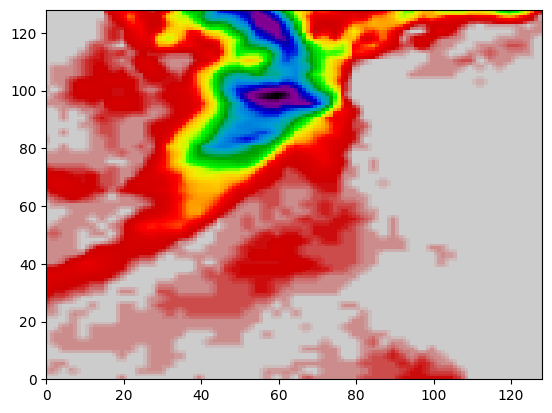

In [99]:
plt.pcolormesh(gfs_, cmap=plt.cm.nipy_spectral_r)

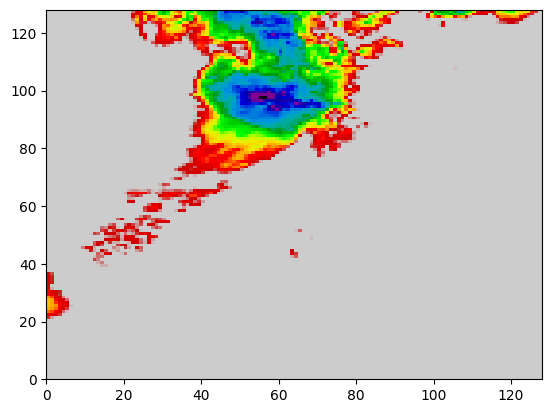

In [100]:
plt.pcolormesh(mrms, cmap=plt.cm.nipy_spectral_r)

In [103]:
t = 25# 20

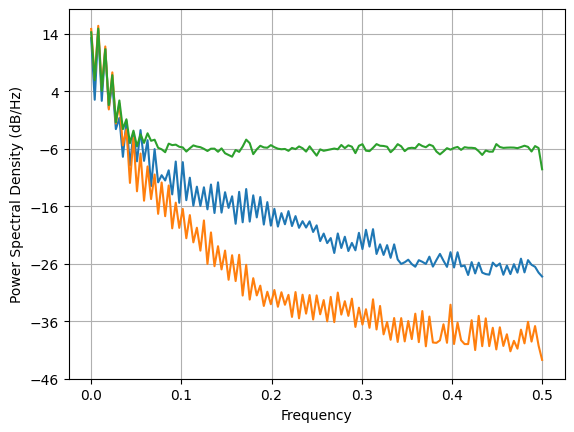

In [104]:
noise_valid = np.random.normal(size=(1, 128, 128))
gfs_noise = np.array(gdf_util.q_sample(gfs_[None, ...], t, noise_valid))
gfs_noise = gfs_noise[0, 0, ...]

plt.psd(mrms.ravel(), Fs=1);
plt.psd(gfs_.ravel(), Fs=1);
plt.psd(gfs_noise.ravel(), Fs=1);

In [108]:
ftimage = np.fft.fft2(images_noise)
ftimage = np.fft.fftshift(ftimage)
ftimage = np.abs(ftimage)

In [109]:
radial_mean = ndimage.mean(ftimage, labels=rbin, index=np.arange(1, rbin.max() +1))

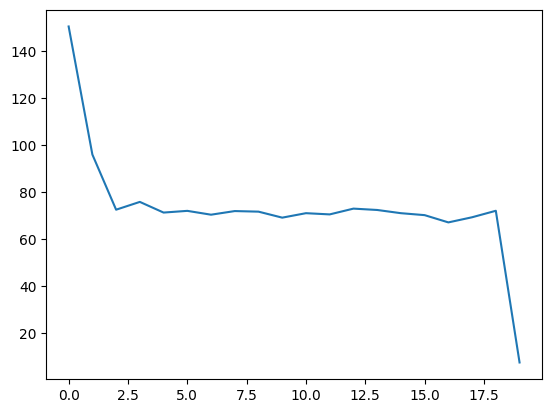

In [110]:
plt.plot(radial_mean)

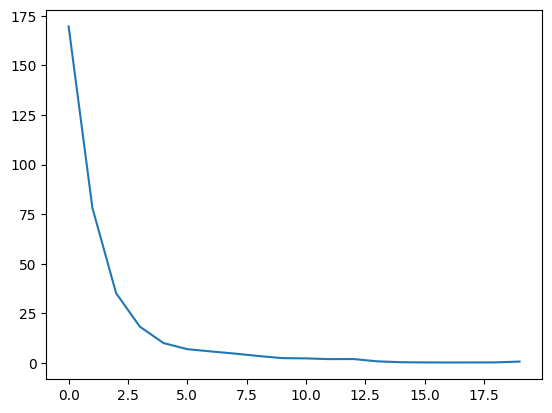

In [81]:
plt.plot(radial_mean)

In [ ]:

plt.figure(figsize=(5, 5))
plt.axes([0, 0, 1, 1])
plt.imshow(rbin, cmap=plt.cm.nipy_spectral)

In [14]:

t = np.arange(256)
fs = 1/t

x = np.sin(t)
freq = np.fft.fftfreq(t.shape[-1])

N = len(x)
xdft = np.fft.fft(x)

psdx = (1/(fs*N)) * np.abs(xdft)**2
psdx = 2*psdx

/glade/derecho/scratch/ksha/tmp/ipykernel_61700/2559549385.py:2: RuntimeWarning: divide by zero encountered in divide
  fs = 1/t


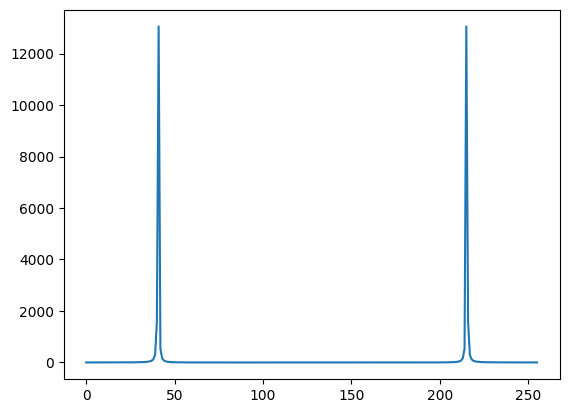

In [19]:
plt.plot(np.abs(xdft)**2)

In [ ]:
imgA = imread('..\\input\\3.bmp');
%imgA = imread('D:\\home\\programming\\vc\\new\\5_Alanis Software\\1_SplitPage\\example2\\resized\\00000110_resized.TIF');

imgA = rgb2gray(imgA); %color->gray
figure; imshow(imgA);
title('Original image');

%PSD calculation
imgA = double(imgA);
img_fft = fft2(imgA);           %spectrum 
img_fft(1,1) = 0;               %removing of constant component
%imgB = img_fft.*conj(img_fft); %Power spectrum density
%imgB = sqrt(imgB);             %sqrt(Power spectrum density)
imgB = abs(img_fft);            %sqrt(Power spectrum density)

imgC = fftshift(255*(imgB -min(min(imgB))) /(max(max(imgB)) - min(min(imgB))));
imgClog = log(1+imgB);
imgClog_norm = fftshift(255*(imgClog -min(min(imgClog))) /(max(max(imgClog)) - min(min(imgClog))));

%ACF calculation
imgD = ifft2(imgB);
imgD(1,1) = 0;
imgE = 255*(imgD -min(min(imgD))) /(max(max(imgD)) - min(min(imgD)));
imgE = fftshift(imgE);


%output
imwrite(uint8(imgC),'..\\output\\PSD_m.jpg');
imwrite(uint8(imgE),'..\\output\\ACF_m.jpg');
imwrite(uint8(imgClog_norm),'..\\output\\PSD_log_m.jpg');
figure, imshow(uint8(imgC));
title('Power spectrum density');
figure, imshow(uint8(imgClog_norm));
title('Power spectrum density Log');
figure, imshow(uint8(imgE));
title('Auto correlation function');